In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

# Model

In [2]:
### physical space, the origin is assumed to be the lower-left corner
xboxsize = 45   # in
yboxsize = 35
Nx = 46  # dx =  1 in
Ny = 36  

# la griglia fisica e' il quadrante upper-right
max_v_swim = 2. #in/s
v_walk = 0.2 # in/s
r = 2 # radius cm
dx = xboxsize/(Nx-1)
# dt = dx/v_walk
dt = 0.5 # MODIFIED
max_range = dt*max_v_swim
nrange = int(max_v_swim/v_walk)

### state space definition
Mx = Nx * 2 -1
My = Ny * 2 -1
xmin, xmax, ymin, ymax = - xboxsize, xboxsize, -yboxsize, yboxsize
xp = np.linspace(xmin,xmax,Mx,endpoint=True)  # state space coordinates
yp = np.linspace(ymin,ymax,My,endpoint=True)
X,Y = np.meshgrid(xp,yp)  # space state grid

In [3]:
# definition of swimming steps
move = []
for i in range(-nrange,nrange+1):
    for j in range(-nrange,nrange+1):
        if (i**2+j**2)*dx**2 == max_range**2: move.append((i,j)) # Only at max range
        # if (i**2+j**2)*dx**2 <= max_range**2: move.append((i,j))

print(f'Available actions: {len(move)}')
# for m in move:
#     print(m)

Available actions: 4


In [4]:
### definition of likelihood, likelihood is defined in the state space
# the likelihood will be defined on the grid state space
likelihood_center = (0,0)
def constant_disk(x,y,xs,ys,r):
    d = np.sqrt((x-xs)**2+(y-ys)**2)
    return np.heaviside(r-d,1)
like = constant_disk(X,Y,likelihood_center[0],likelihood_center[1],r)
env_shape = like.shape

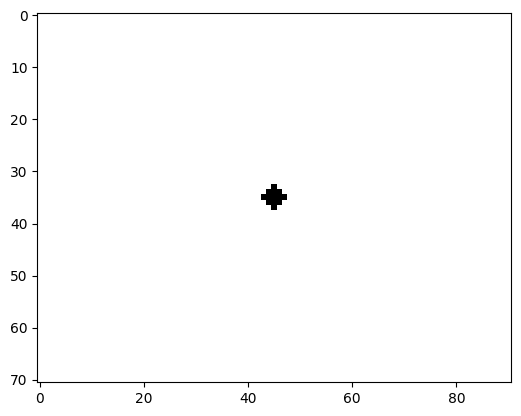

In [5]:
plt.imshow(like, cmap='Greys')

In [6]:
### POMDP states definition
state_grid = []  # this is a list of My lists of Mx strings (state labels) each
# State labels
for i in range(env_shape[0]): # My
    i_states = []
    for j in range(env_shape[1]): # Mx
        i_states.append(f's_{i}_{j}') # s_yind_xind
    state_grid.append(i_states)
state_count = Mx * My

In [7]:
reachable_states = np.full(shape=(state_count, len(move)), fill_value=-1)

for x in range(env_shape[0]):
    for y in range(env_shape[1]):
        for a, m in enumerate(move):
            pos = np.array([x,y])
            m = np.array(m)

            new_pos = pos + m

            # Handle border for new pos
            new_pos = new_pos % np.array(env_shape)
            new_pos[0] = new_pos[0] + env_shape[0] if new_pos[0] < 0 else new_pos[0]
            new_pos[1] = new_pos[1] + env_shape[1] if new_pos[1] < 0 else new_pos[1]

            # Flatten pos
            flat_pos = (env_shape[1] * pos[0]) + pos[1]
            flat_new_pos = (env_shape[1] * new_pos[0]) + new_pos[1]
            reachable_states[flat_pos, a] = flat_new_pos

reachable_states = reachable_states[:,:,None]

In [8]:
# Reward function
def reward_func(s,a,sn,o):
    return np.where(sn == (Mx*(My-1)/2 + (Mx-1)/2), 1.0, 0.0)

In [9]:
# flatten mette di default tutte le righe una in fila all'altra shape = (shape[0]*shape[1],), [:,None] rende questo vettore riga un matrice con una colonna shape = (shape[0]*shape[1],1)
observations = np.concatenate((like.flatten()[:,None], (1-like.flatten()[:,None])),axis=1)
# shape is (like.shape[0]*like.shape[1],2)
observations = observations.reshape(state_count,1,2).repeat(len(move), axis=1) #Repeat for each action
# observation shape = (number of states,n actions, n observation values)

In [10]:
model = Model(
    states=state_grid,
    actions=move,
    observations=['something', 'nothing'],
    reachable_states=reachable_states,
    rewards=reward_func,
    observation_table=observations,
    end_states=[(Mx*(My-1)/2 + (Mx-1)/2)]
    )

[04/11/2024, 15:44:30] Instantiation of MDP Model:
[04/11/2024, 15:44:30] - 6461 states
[04/11/2024, 15:44:30] - 4 actions
[04/11/2024, 15:44:30] - At most 1 reachable states per state-action pair
[04/11/2024, 15:44:30] - Starting generation of transitions table
[04/11/2024, 15:44:30]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[04/11/2024, 15:44:30]     > Done in 0.000s
[04/11/2024, 15:44:30] - Generation of state grid
[04/11/2024, 15:44:30] - Generating start probabilities table
[04/11/2024, 15:44:30] - Starting computation of reachable state probabilities from transition data
[04/11/2024, 15:44:30]     > Done in 0.000s

[04/11/2024, 15:44:30] POMDP particular parameters:
[04/11/2024, 15:44:30] - 2 observations
[04/11/2024, 15:44:30] - Starting of transitional observations for reachable states table
[04/11/2024, 15:44:30]     > Done in 0.001s
[04/11/20

# MDP solution

In [11]:
from src.mdp import VI_Solver

solver = VI_Solver(eps=1e-3)
solution, history = solver.solve(model, use_gpu=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


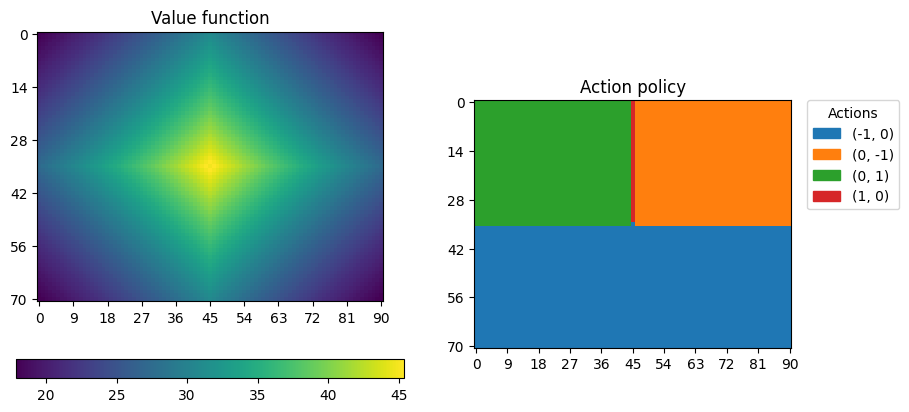

In [12]:
solution.plot()

In [13]:
m_array = np.array(move)

In [14]:
m_array_alt = m_array[:,0] + (m_array[:,1] * 1j)

In [15]:
m_angles = np.angle(m_array_alt)

In [16]:
angle_map = m_angles[solution.actions[np.argmax(solution.alpha_vector_array, axis=0)]].reshape(env_shape)

In [17]:
m_array

array([[-1,  0],
       [ 0, -1],
       [ 0,  1],
       [ 1,  0]])

In [18]:
m_angles

array([ 3.14159265, -1.57079633,  1.57079633,  0.        ])

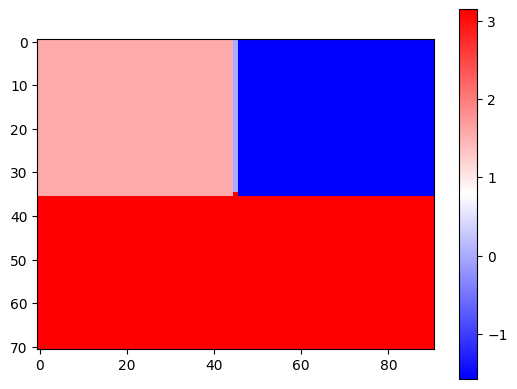

In [19]:
plt.imshow(angle_map, cmap='bwr')
plt.colorbar()

# Training

In [20]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-8, mdp_policy=solution)

fsvi_solution, hist = fsvi_solver.solve(model=model,
                                        max_belief_growth=100,
                                        expansions=200,
                                        print_progress=True,
                                        # expand_prune_level=2,
                                        use_gpu=False)
                                    
print(hist.summary)

Expansions:   0%|          | 0/200 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 6461 state, 4 action, 2 observations
  - Converged or stopped after 200 expansion steps and 200 backup steps.
  - Resulting value function has 2403 alpha vectors.
  - Converged in 251.7429s

  - Expand function took on average 0.0192s and yielded on average 2385.58 beliefs per iteration. (0.0000s/it/belief)
  - Backup function took on average 1.2395s and yielded on average 11.99 alpha vectors per iteration. (0.0012s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


# Test

In [21]:
a = Agent(model=model, value_function=fsvi_solution)

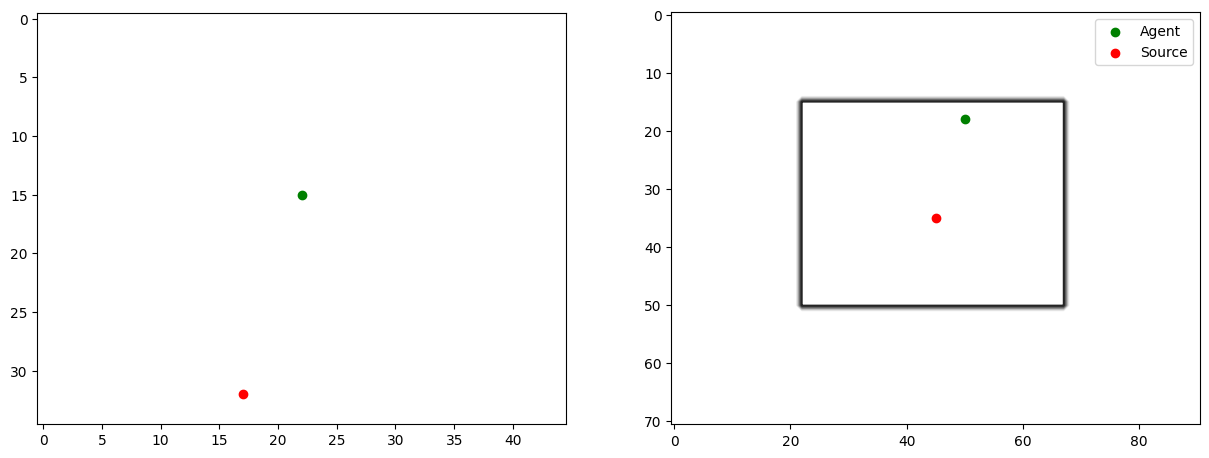

In [105]:
tank_size = np.array([yboxsize, xboxsize])

# PHYSICAL SPACE
source_point = (np.random.random(2) * tank_size).astype(int)
agent_start = (np.random.random(2) * tank_size).astype(int)

fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(15,10))

ax0.imshow(np.zeros(tank_size), cmap='Greys')
ax0.scatter(source_point[1], source_point[0], c='red', label='Source')
ax0.scatter(agent_start[1], agent_start[0], c='green', label='Agent')

# STATE SPACE
center_state = agent_start
agent_start_state = center_state + (tank_size - source_point)

belief = np.zeros(env_shape)
belief[center_state[0]:center_state[0]+tank_size[0]+1, center_state[1]:center_state[1]+tank_size[1]+1] = 1
belief /= np.sum(belief)

ax1.imshow(np.zeros(env_shape), cmap='Greys')
ax1.contour(belief, cmap='Greys')
# ax1.invert_yaxis()
ax1.scatter(agent_start_state[1], agent_start_state[0], c='green', label='Agent')
ax1.scatter(tank_size[1], tank_size[0], c='red', label='Source')
ax1.legend()

In [106]:
agent_start_flat = (env_shape[1] * agent_start_state[0]) + agent_start_state[1]
hist = a.simulate(start_state=agent_start_flat, initial_belief=Belief(model, belief.flatten()))

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulation done:
	- Runtime (s): 3.410121
	- Steps: 325
	- Total rewards: 1.0
	- End state: s_35_45


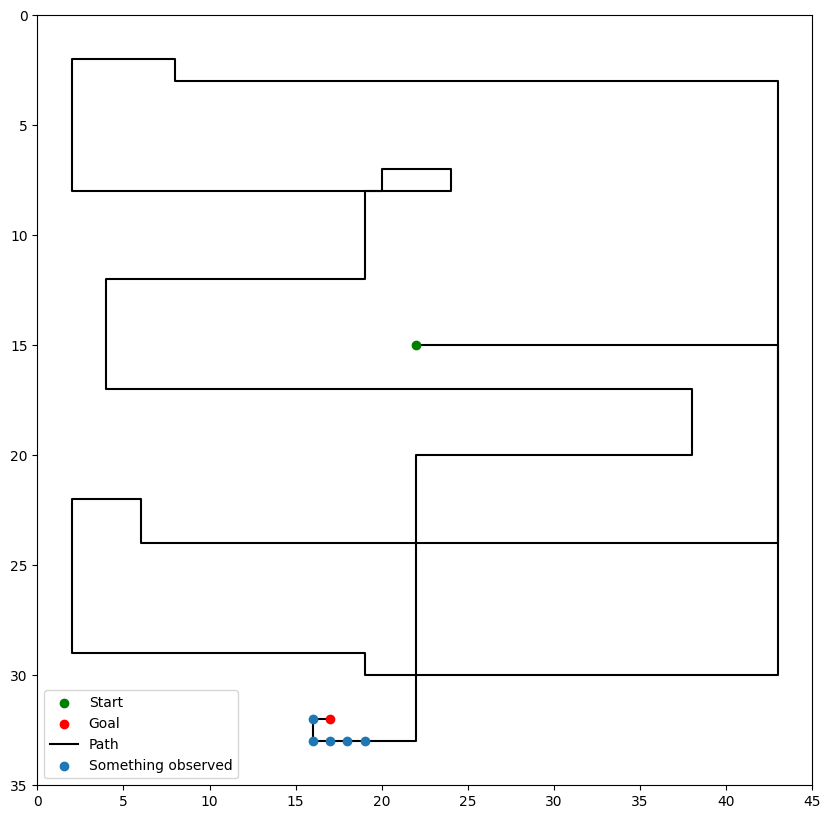

In [107]:
fig, ax = plt.subplots(figsize=(10,10))

# Initial clearing
ax.clear()

# Get cpu model
model = hist.model.cpu_model

# Plot setup
env_shape = model.cpu_model.state_grid.shape
ax.set_xlim(0, tank_size[1])
ax.set_ylim(tank_size[0], 0)

# Compute shift
shift = (hist.grid_point_sequence[0] - agent_start)

# Start
start_coord = hist.grid_point_sequence[0] - shift
ax.scatter(start_coord[1], start_coord[0], c='green', label='Start')

# Goal
goal_coord = source_point[None,:]
ax.scatter(goal_coord[:,1], goal_coord[:,0], c='red', label='Goal')

# Until step
seq = np.array(hist.grid_point_sequence) - shift[None,:]

# Path
ax.plot(seq[:,1], seq[:,0], zorder=-1, c='black', label='Path')

# Something sensed
something_obs_id = model.observation_labels.index('something')
obs_ts = np.where(np.array(hist.observations[:]) == something_obs_id)
points_obs = seq[obs_ts[0],:]
ax.scatter(points_obs[:,1], points_obs[:,0], zorder=1, label='Something observed')

# Generate legend
ax.legend()

In [27]:
agent_start_flat = (env_shape[1] * agent_start[0]) + agent_start[1]
hist = a.run_n_simulations(n=10, start_states=agent_start_flat, initial_beliefs=Belief(model, belief.flatten()))

  0%|          | 0/10 [00:00<?, ?it/s]

All 10 simulations done:
	- Average runtime (s): 2.3657634
	- Simulations reached goal: 10/10 (0 failures)
	- Average step count: 237.0
	- Average total rewards: 1.0
	- Average discounted rewards (ADR): 0.0942476934556249


In [34]:
agent_start_flat = (env_shape[1] * agent_start[0]) + agent_start[1]
hist = a.run_n_simulations_parallel(n=10, start_states=int(agent_start_flat), initial_beliefs=Belief(model, belief.flatten()))

  0%|          | 0/1000 [00:00<?, ?it/s]

IndexError: arrays used as indices must be of integer (or boolean) type

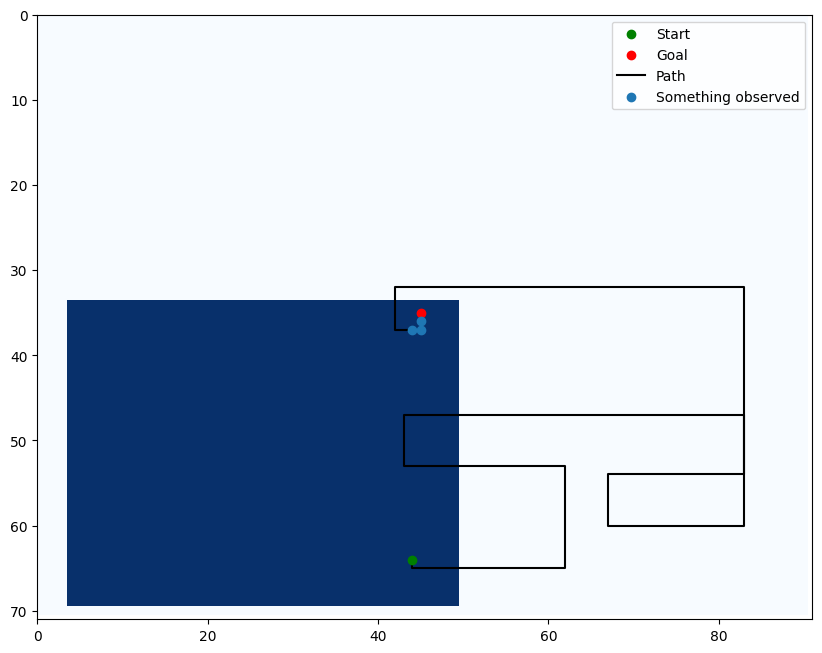

In [85]:
fig, ax = plt.subplots(figsize=(10,10))
plot_steps(hist, ax=ax)
ax.imshow(belief, cmap='Blues', zorder=-10)


In [101]:
hist.save_simulation_video()

Folder "./Sim Videos" does not exist yet, creating it...
Video saved at './Sim Videos/s6461-a4-20240411_151506.mp4'...


In [39]:
start_positions = np.argwhere(model.start_probabilities > 0)[:,0].tolist()

6461

In [43]:
_, hist = a.run_n_simulations_parallel(n=len(start_positions), start_state=start_positions)

  0%|          | 0/1000 [00:00<?, ?it/s]

All 6461 simulations done in 1460.500s:
	- Simulations reached goal: 4237/6461 (2224 failures)
	- Average step count: 647.1877418356291
	- Average total rewards: 0.6557808388794304
	- Average discounted rewards (ADR): 0.0725450244308042


In [44]:
# Saving simulation
import json

all_seq = np.empty((len(hist), 1001), dtype=object)
for sim_i, sim in enumerate(hist):
    seq = []
    for s, a, o, r in zip(sim.states, sim.actions+[], sim.observations+[], sim.rewards+[]):
        seq.append(json.dumps({'s':s, 'a':a, 'o':o, 'r':r}))
    
    all_seq[sim_i, :len(seq)] = seq

sim_df = pd.DataFrame(all_seq.T, columns=[f'Sim-{sim_i}' for sim_i in range(len(hist))])
# sim_df.to_csv(f'./run-q_learning_comp-sims.csv')

In [24]:
def plot_steps(sim_hist:SimulationHistory, until_step:int=-1, ax=None) -> None:
    '''
    Plots a special version of the simulation plot for olfactory navigation
    
    Parameters
    ----------
    sim_hist : SimulationHistory
        The completed simulation history.
    ax : optional
        The ax the produce the plot on, if not a new one will be created.
    '''
    # Generate ax is not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))

    # Initial clearing
    ax.clear()

    # Get cpu model
    model = sim_hist.model.cpu_model

    # Plot setup
    env_shape = model.cpu_model.state_grid.shape
    ax.set_xlim(0, env_shape[1])
    ax.set_ylim(env_shape[0], 0)

    # Start
    start_coord = sim_hist.grid_point_sequence[0]
    ax.scatter(start_coord[1], start_coord[0], c='green', label='Start')

    # Goal
    goal_coord = np.array([np.argwhere(model.state_grid == g)[0].tolist() for g in model.end_states])
    ax.scatter(goal_coord[:,1], goal_coord[:,0], c='red', label='Goal')

    # Until step
    seq = np.array(sim_hist.grid_point_sequence)
    if until_step < 0:
        until_step = len(seq) - 1

    # Path
    ax.plot(seq[:until_step+1,1], seq[:until_step+1,0], zorder=-1, c='black', label='Path')

    # Something sensed
    something_obs_id = model.observation_labels.index('something')
    obs_ts = np.where(np.array(sim_hist.observations[:until_step]) == something_obs_id)
    points_obs = seq[obs_ts[0],:]
    ax.scatter(points_obs[:,1], points_obs[:,0], zorder=1, label='Something observed')

    # Points sniff
    # sniff_air_action_id = -1
    # for i, al in enumerate(model.action_labels):
    #     if 'air' in al.lower():
    #         sniff_air_action_id = i
    # sniff_in_air = np.where(np.array(sim_hist.actions[:until_step]) == sniff_air_action_id)
    # points_sniff = seq[sniff_in_air[0],:]
    # if len(points_sniff) > 0:
    #     ax.scatter(points_sniff[:,1], points_sniff[:,0], zorder=2, marker='x', label='Sniff in the air')

    # Generate legend
    ax.legend()

AttributeError: 'tuple' object has no attribute 'lower'

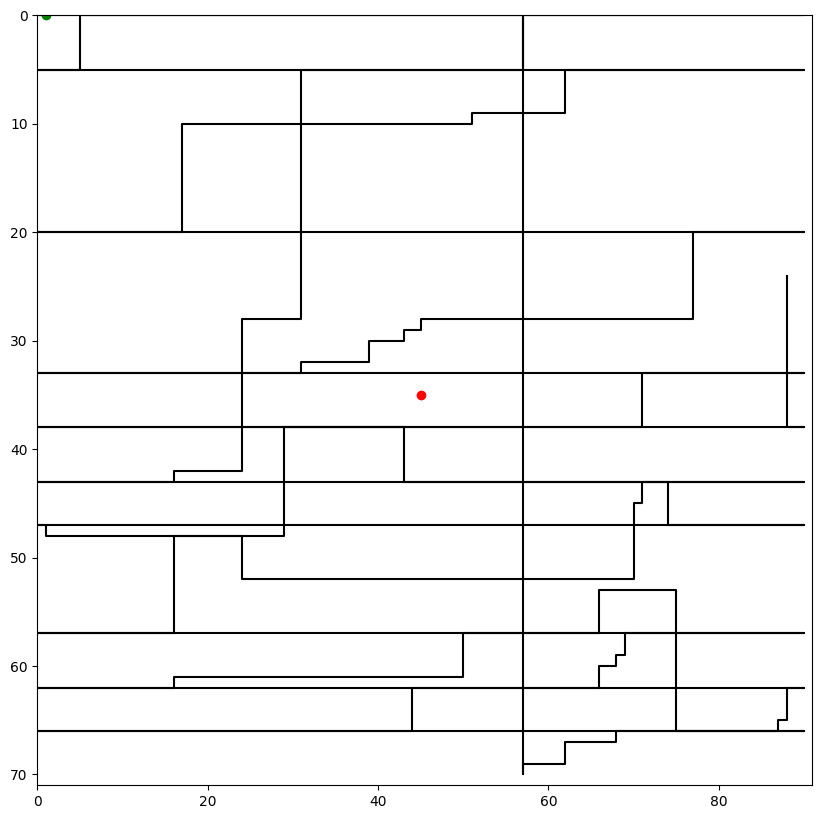

In [48]:
plot_steps(hist[1])